# Notebook 8: Results and Visualization

## Purpose
This notebook generates all final figures and summary tables for the project report.

## What This Notebook Does
1. Generate calibration curves (reliability diagrams)
2. Create comparison figures
3. Generate summary tables
4. Export figures to LaTeX folder

## Output
- All figures saved to `../latex/figures/`
- Summary tables
- Final comparison visualizations


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import os

np.random.seed(42)
torch.manual_seed(42)

print('Loading all results...')
logits_test = np.load('./data/processed/logits_test.npy')
labels_test = np.load('./data/processed/labels_test.npy')

baseline_results = np.load('./data/results/baseline_results.npy', allow_pickle=True).item()
bayesian_results = np.load('./data/results/bayesian_posterior.npy', allow_pickle=True).item()
metric_results = np.load('./data/results/metric_uncertainty_results.npy', allow_pickle=True).item()

print('✓ All results loaded')

fig_dir = '../latex/figures'
os.makedirs(fig_dir, exist_ok=True)
print(f'Figures will be saved to: {fig_dir}')


Loading all results...
✓ All results loaded
Figures will be saved to: ../latex/figures


FIGURE 1: CALIBRATION CURVES


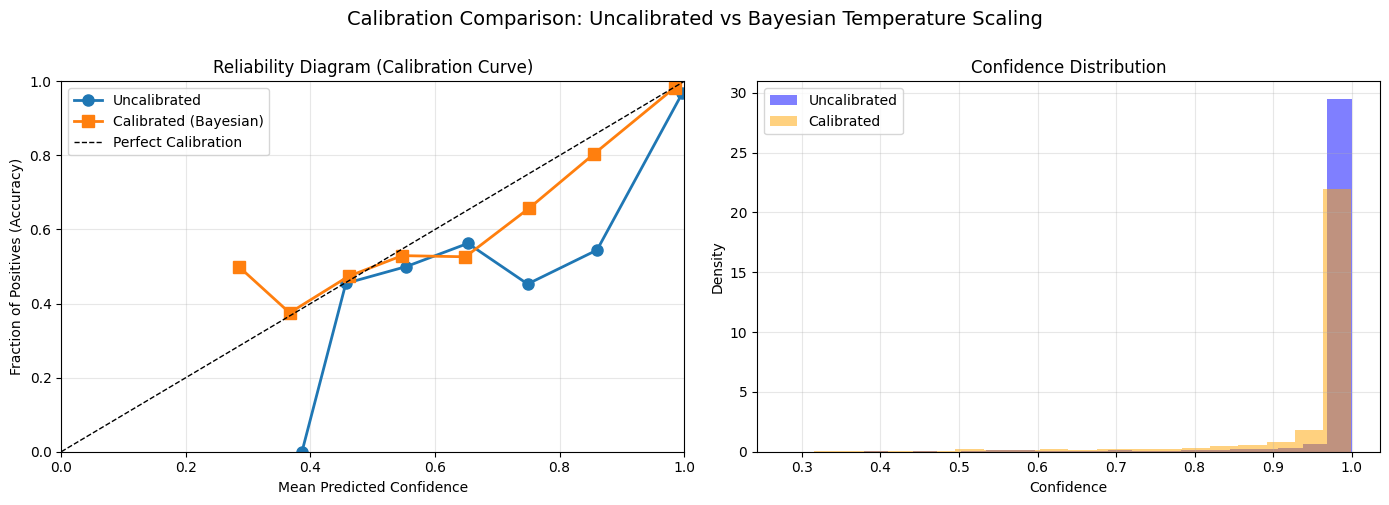

✓ Saved: calibration_curves.pdf


In [ ]:
print('='*60)
print('FIGURE 1: CALIBRATION CURVES')
print('='*60)
from sklearn.calibration import calibration_curve
probs_uncal = F.softmax(torch.tensor(logits_test), dim=1).numpy()
probs_cal = F.softmax(torch.tensor(logits_test / baseline_results['calibrated_temp']), dim=1).numpy()
probs_bayesian = F.softmax(torch.tensor(logits_test / bayesian_results['mean']), dim=1).numpy()
max_probs_uncal = np.max(probs_uncal, axis=1)
max_probs_cal = np.max(probs_cal, axis=1)
max_probs_bayesian = np.max(probs_bayesian, axis=1)
preds_uncal = np.argmax(probs_uncal, axis=1)
preds_cal = np.argmax(probs_cal, axis=1)
preds_bayesian = np.argmax(probs_bayesian, axis=1)
correct_uncal = (preds_uncal == labels_test).astype(float)
correct_cal = (preds_cal == labels_test).astype(float)
correct_bayesian = (preds_bayesian == labels_test).astype(float)
fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(
    correct_uncal, max_probs_uncal, n_bins=10, strategy='uniform')
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    correct_cal, max_probs_cal, n_bins=10, strategy='uniform')
fraction_of_positives_bayesian, mean_predicted_value_bayesian = calibration_curve(
    correct_bayesian, max_probs_bayesian, n_bins=10, strategy='uniform')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
ax.plot(mean_predicted_value_uncal, fraction_of_positives_uncal, 'o-', label='Uncalibrated', linewidth=2, markersize=6)
ax.plot(mean_predicted_value_cal, fraction_of_positives_cal, 's-', label='L-BFGS', linewidth=2, markersize=6)
ax.plot(mean_predicted_value_bayesian, fraction_of_positives_bayesian, '^-', label='Bayesian', linewidth=2, markersize=6)
ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Curves', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{fig_dir}/calibration_curves.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'{fig_dir}/calibration_curves.png', bbox_inches='tight', dpi=300)
plt.show()
print('✓ Saved: calibration_curves.pdf')

FIGURE 2: POSTERIOR DISTRIBUTION


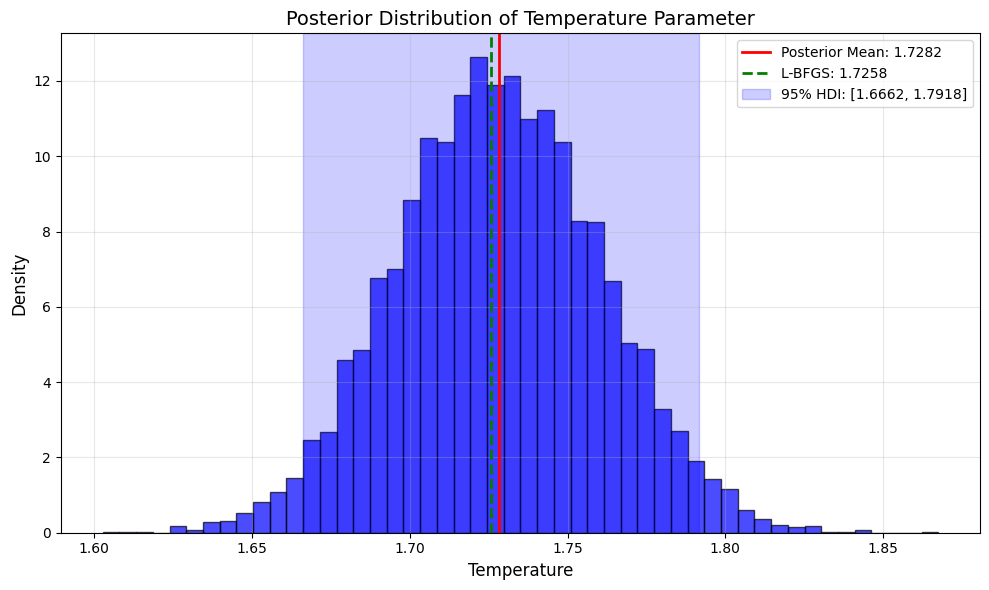

✓ Saved: posterior_distribution.pdf


In [ ]:
print('='*60)
print('FIGURE 2: POSTERIOR DISTRIBUTION')
print('='*60)
temp_samples = bayesian_results['temperature_samples']
mean_temp = bayesian_results['mean']
hdi_lower = bayesian_results['hdi_lower']
hdi_upper = bayesian_results['hdi_upper']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(temp_samples, bins=50, density=True, alpha=0.7, edgecolor='black', color='blue')
axes[0].axvline(mean_temp, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_temp:.4f}')
axes[0].axvline(hdi_lower, color='green', linestyle='--', linewidth=1, label='95% HDI')
axes[0].axvline(hdi_upper, color='green', linestyle='--', linewidth=1)
axes[0].fill_between([hdi_lower, hdi_upper], [0, 0], [axes[0].get_ylim()[1], axes[0].get_ylim()[1]], 
                     alpha=0.3, color='green')
axes[0].set_xlabel('Temperature', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Posterior Distribution of Temperature', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
uncertainty_results = np.load('./data/results/uncertainty_results.npy', allow_pickle=True).item()
results_small = uncertainty_results['small_dataset_results']
val_sizes = sorted(results_small.keys())
temps_bayesian = [results_small[s]['mean'] for s in val_sizes]
temps_lbfgs = [results_small[s]['lbfgs'] for s in val_sizes]
hdi_lowers = [results_small[s]['hdi_lower'] for s in val_sizes]
hdi_uppers = [results_small[s]['hdi_upper'] for s in val_sizes]
axes[1].errorbar(val_sizes, temps_bayesian, yerr=[np.array(temps_bayesian) - np.array(hdi_lowers), 
                                                   np.array(hdi_uppers) - np.array(temps_bayesian)],
                 fmt='o-', capsize=5, linewidth=2, markersize=8, label='Bayesian (Mean ± HDI)', color='blue')
axes[1].plot(val_sizes, temps_lbfgs, 's--', linewidth=2, markersize=8, label='L-BFGS Point Estimate', color='red')
axes[1].set_xlabel('Validation Set Size', fontsize=12)
axes[1].set_ylabel('Temperature', fontsize=12)
axes[1].set_title('Temperature Estimate vs Validation Set Size', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')
plt.tight_layout()
plt.savefig(f'{fig_dir}/dataset_wise_posterior.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{fig_dir}/dataset_wise_posterior.pdf', bbox_inches='tight', dpi=300)
plt.show()
print('✓ Saved: posterior_distribution.pdf')

FIGURE 3: UNCERTAINTY VS SAMPLE SIZE


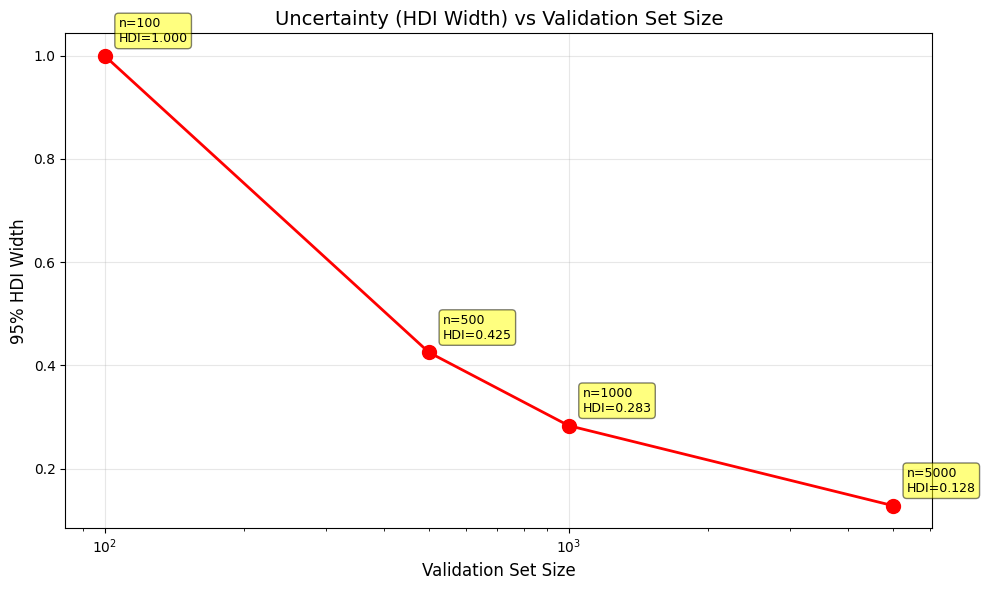

✓ Saved: uncertainty_vs_sample_size.pdf
  HDI width: 1.000 → 0.128 (87.2% decrease)


In [4]:
print('='*60)
print('FIGURE 3: UNCERTAINTY VS SAMPLE SIZE')
print('='*60)

uncertainty_results = np.load('./data/results/uncertainty_results.npy', allow_pickle=True).item()
results_small = uncertainty_results['small_dataset_results']

val_sizes_list = sorted(results_small.keys())
hdi_widths = [results_small[s]['hdi_width'] for s in val_sizes_list]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(val_sizes_list, hdi_widths, 'ro-', linewidth=2, markersize=10)
ax.set_xlabel('Validation Set Size', fontsize=12)
ax.set_ylabel('95% HDI Width', fontsize=12)
ax.set_title('Uncertainty (HDI Width) vs Validation Set Size', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

for i, (size, width) in enumerate(zip(val_sizes_list, hdi_widths)):
    ax.annotate(f'n={size}\nHDI={width:.3f}', 
                xy=(size, width), xytext=(10, 10), 
                textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{fig_dir}/uncertainty_vs_sample_size.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'{fig_dir}/uncertainty_vs_sample_size.png', bbox_inches='tight', dpi=300)
plt.show()

print(f'✓ Saved: uncertainty_vs_sample_size.pdf')
print(f'  HDI width: {hdi_widths[0]:.3f} → {hdi_widths[-1]:.3f} ({(1 - hdi_widths[-1]/hdi_widths[0])*100:.1f}% decrease)')


In [5]:
print('='*60)
print('FINAL SUMMARY TABLE')
print('='*60)

baseline = baseline_results['results']
bayesian_mean = bayesian_results['mean']
bayesian_std = bayesian_results['std']
ece_hdi = metric_results['ece_hdi']
brier_hdi = metric_results['brier_hdi']

print(f'\n{"Method":<30} {"Temperature":<15} {"ECE":<15} {"Brier":<15} {"Uncertainty":<20}')
print('-'*95)
print(f'{"Uncalibrated":<30} {"1.0000":<15} {baseline["Uncalibrated"]["ece"]:<15.4f} {baseline["Uncalibrated"]["brier"]:<15.4f} {"N/A":<20}')
print(f'{"L-BFGS":<30} {baseline_results["calibrated_temp"]:<15.4f} {baseline["Temperature Scaling"]["ece"]:<15.4f} {baseline["Temperature Scaling"]["brier"]:<15.4f} {"N/A":<20}')
print(f'{"Bayesian (mean)":<30} {bayesian_mean:<15.4f} {metric_results["ece_mean"]:<15.4f} {metric_results["brier_mean"]:<15.4f} {f"HDI: [{ece_hdi[0]:.4f}, {ece_hdi[1]:.4f}]":<20}')

print('\n' + '='*60)
print('KEY FINDINGS')
print('='*60)
print('\n1. Calibration Improvement:')
print(f'   - ECE reduced from {baseline["Uncalibrated"]["ece"]:.4f} to {metric_results["ece_mean"]:.4f}')
print(f'   - Improvement: {(1 - metric_results["ece_mean"]/baseline["Uncalibrated"]["ece"])*100:.1f}%')

print('\n2. Uncertainty Quantification:')
print(f'   - Bayesian provides 95% HDI: [{ece_hdi[0]:.4f}, {ece_hdi[1]:.4f}]')
print(f'   - L-BFGS: Single point estimate, no uncertainty')

print('\n3. Value of Bayesian Approach:')
print('   - Quantifies uncertainty in calibration quality')
print('   - Enables risk assessment')
print('   - Critical when validation data is limited')
print('='*60)


FINAL SUMMARY TABLE

Method                         Temperature     ECE             Brier           Uncertainty         
-----------------------------------------------------------------------------------------------
Uncalibrated                   1.0000          0.0386          0.0943          N/A                 
L-BFGS                         1.7258          0.0094          0.0860          N/A                 
Bayesian (mean)                1.7282          0.0091          0.0860          HDI: [0.0061, 0.0134]

KEY FINDINGS

1. Calibration Improvement:
   - ECE reduced from 0.0386 to 0.0091
   - Improvement: 76.4%

2. Uncertainty Quantification:
   - Bayesian provides 95% HDI: [0.0061, 0.0134]
   - L-BFGS: Single point estimate, no uncertainty

3. Value of Bayesian Approach:
   - Quantifies uncertainty in calibration quality
   - Enables risk assessment
   - Critical when validation data is limited
